In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC # Tres efficasse sur les petits data frame
from sklearn.neighbors import KNeighborsClassifier

In [3]:
data = pd.read_excel("covid_dataset.xlsx") # `$ conda install openpyxl` is needed

# Re-crée la procedure d'evaluation

In [5]:
df = data.copy()

missing_rate = df.isna().sum()/df.shape[0]

blood_columns = list(df.columns[(missing_rate < 0.9) & (missing_rate >0.88)])
viral_columns = list(df.columns[(missing_rate < 0.80) & (missing_rate > 0.75)])

key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

df = df[key_columns + blood_columns + viral_columns]

In [6]:
def encodage(df:pd.DataFrame):
    code = {'negative':0,
            'positive':1,
            'not_detected':0,
            'detected':1}
    
    for col in df.select_dtypes("object") :
        df[col] = df[col].map(code)
        
    return df

In [7]:
def imputation(df):
    return df.dropna(axis=0)

In [10]:
def preprocessing(df:pd.DataFrame):
    
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)

    X = df.drop("SARS-Cov-2 exam result", axis=1)
    y = df["SARS-Cov-2 exam result"]
    
    print(y.value_counts())
    
    return X, y

In [9]:
def feature_engineering(df):
    df['est malade'] = df[viral_columns].sum(axis=1) >= 1
    df = df.drop(viral_columns, axis=1)
    return df

In [32]:
def evaluation(model, df, plot=True, name=None):
    
    trainset, testset = train_test_split(df, test_size=0.2, random_state=0)
    
    X_train, y_train = preprocessing(trainset)
    X_test, y_test = preprocessing(testset)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
          
    N, train_score, val_score = learning_curve(model, X_train, y_train,cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    if plot :
        plt.figure(figsize=(12, 8))
        plt.plot(N, train_score.mean(axis=1), label="train score")
        plt.plot(N, val_score.mean(axis=1), label="val score")
        plt.title(name)
        plt.legend()
    
    return df, X_train

In [64]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64


# Modelisation

In [19]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), 
                             SelectKBest(f_classif, k=10))

# include_bias=False => supprime les colonnes constante

In [41]:
RandomForest_pipeline = make_pipeline(preprocessor, 
                             RandomForestClassifier(random_state=0))

AdaBoost_pipeline = make_pipeline(preprocessor, 
                         AdaBoostClassifier(random_state=0))

SVC_pipeline = make_pipeline(preprocessor, 
                    StandardScaler(), # on normalise
                    SVC(random_state=0))

KNN_pipeline = make_pipeline(preprocessor, 
                    StandardScaler(), # on normalise
                    KNeighborsClassifier())

# On n'avait pas normalisé car on utilisait des arbres de decision, qui n'on pas besoin de normalisé les données
# On pourrait Factorisé `preprocessor`

In [42]:
models = {'RandomForest': RandomForest_pipeline,
                  'AdaBoost' : AdaBoost_pipeline,
                  'SVC': SVC_pipeline,
                  'KNN': KNN_pipeline
                 }

RandomForest
0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111

AdaBoost
0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111

SVC
0    422
1     65
Name: SARS-Cov-2 exam re

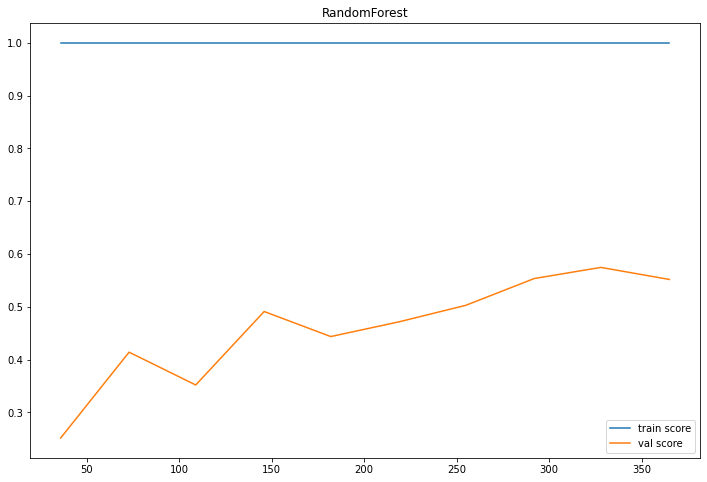

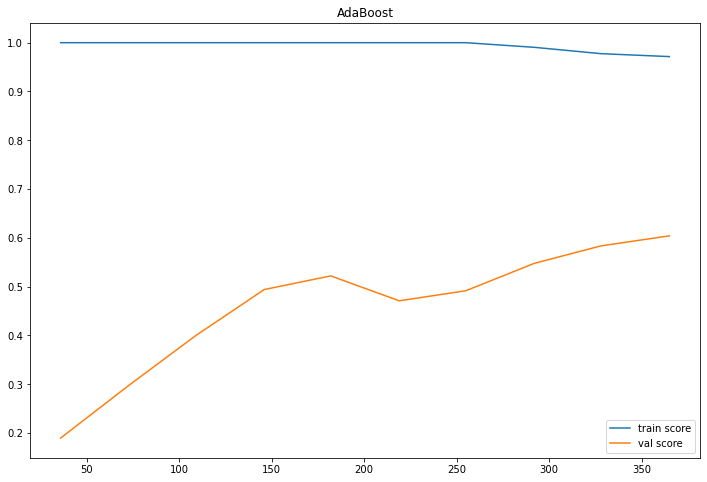

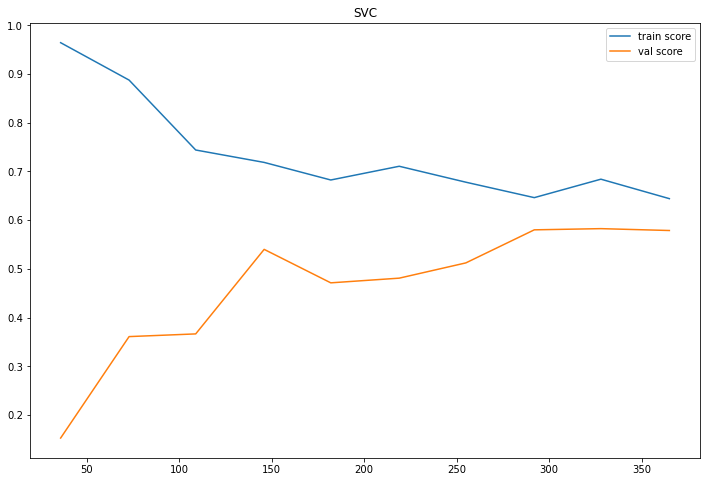

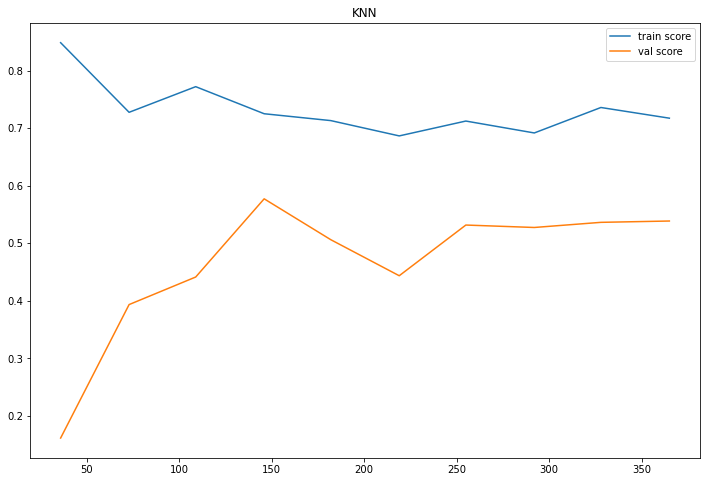

In [43]:
for name, model in models.items():
    print(name)
    evaluation(model, df, name=name)

**`SVC`semble prometteur car il n'overfit pas (ou peu)**<br>
**`Adaboost` semble egalement prometteur, due a ca pente de progression**

## Optimisation

In [44]:
from sklearn.model_selection import GridSearchCV

In [46]:
SVC_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

{'svc__C': 10.0, 'svc__gamma': 0.1}
0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111



(      Patient age quantile SARS-Cov-2 exam result  Hematocrit  Hemoglobin  \
 0                       13               negative         NaN         NaN   
 1                       17               negative    0.236515   -0.022340   
 2                        8               negative         NaN         NaN   
 3                        5               negative         NaN         NaN   
 4                       15               negative         NaN         NaN   
 ...                    ...                    ...         ...         ...   
 5639                     3               positive         NaN         NaN   
 5640                    17               negative         NaN         NaN   
 5641                     4               negative         NaN         NaN   
 5642                    10               negative         NaN         NaN   
 5643                    19               positive    0.694287    0.541564   
 
       Platelets  Mean platelet volume   Red blood Cells  Lymp

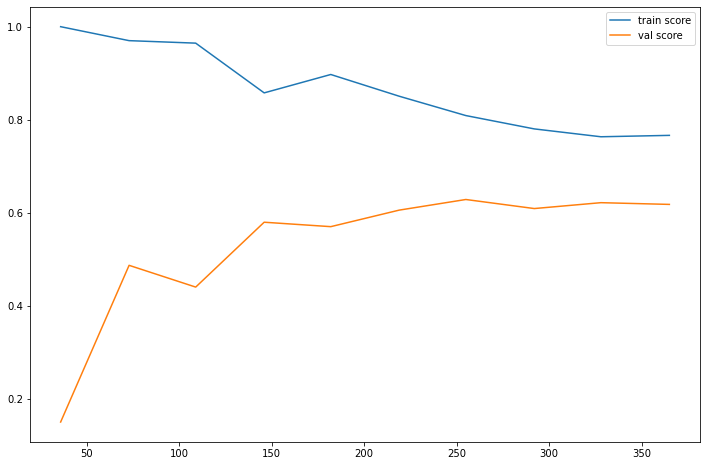

In [75]:
hyper_params = {
    "svc__gamma":np.logspace(-4,0,5), # [1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]
    "svc__C":np.logspace(0,4,5) # [1, 10, 100, 1_000, 10_000]
}

grid_svc = GridSearchCV(SVC_pipeline, hyper_params, scoring="recall", cv=4)

grid_svc.fit(X_train, y_train)

print(grid_svc.best_params_)

y_pred = grid_svc.predict(X_test)

evaluation(grid_svc.best_estimator_, df)

In [63]:
grid_svc.best_params_

{'svc__C': 10.0, 'svc__gamma': 0.1}

In [65]:
grid_svc.score(X_test, y_test)

0.4375

### `RandomizedSearchCV`

In [66]:
from sklearn.model_selection import RandomizedSearchCV

{'svc__gamma': 0.001, 'svc__C': 1000, 'pipeline__selectkbest__k': 51, 'pipeline__polynomialfeatures__degree': 3}
0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[89  6]
 [ 8  8]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        95
           1       0.57      0.50      0.53        16

    accuracy                           0.87       111
   macro avg       0.74      0.72      0.73       111
weighted avg       0.87      0.87      0.87       111



(      Patient age quantile SARS-Cov-2 exam result  Hematocrit  Hemoglobin  \
 0                       13               negative         NaN         NaN   
 1                       17               negative    0.236515   -0.022340   
 2                        8               negative         NaN         NaN   
 3                        5               negative         NaN         NaN   
 4                       15               negative         NaN         NaN   
 ...                    ...                    ...         ...         ...   
 5639                     3               positive         NaN         NaN   
 5640                    17               negative         NaN         NaN   
 5641                     4               negative         NaN         NaN   
 5642                    10               negative         NaN         NaN   
 5643                    19               positive    0.694287    0.541564   
 
       Platelets  Mean platelet volume   Red blood Cells  Lymp

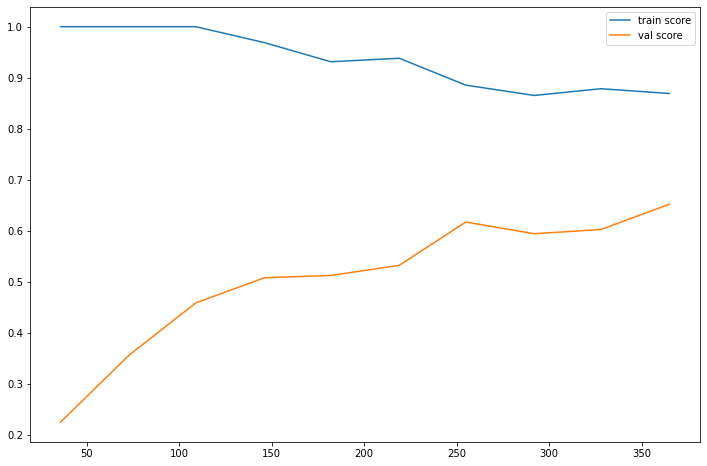

In [84]:
hyper_params = {'svc__gamma':[1e-3, 1e-4, 0.0005],
                'svc__C':[1, 10, 100, 1000, 3000], 
               'pipeline__polynomialfeatures__degree':[2, 3],
               'pipeline__selectkbest__k': range(45, 60)}

random_grid_svc = RandomizedSearchCV(SVC_pipeline, hyper_params, scoring='recall', cv=4,
                          n_iter=40)

random_grid_svc.fit(X_train, y_train)

print(random_grid_svc.best_params_)

y_pred = random_grid_svc.predict(X_test)

evaluation(random_grid_svc.best_estimator_, df)

## Precision Recall Curve

In [85]:
from sklearn.metrics import precision_recall_curve
best_model = random_grid_svc.best_estimator_

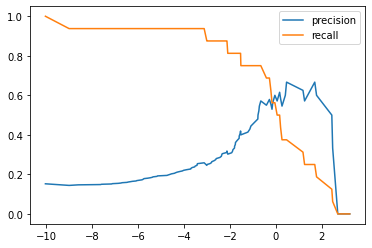

In [86]:
precision, recall, threshold = precision_recall_curve(y_test, best_model.decision_function(X_test))

plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [87]:
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold

# Rq: 
# np.all(model_final(best_model, X_test) == best_model.predict(X_test)) >>> True

In [92]:
np.all(model_final(best_model, X_test) == best_model.predict(X_test))

True

In [88]:
y_pred = model_final(best_model, X_test, threshold=-1)
y_pred

array([ True, False, False, False, False,  True, False,  True, False,
       False, False, False, False, False, False,  True, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
        True,  True,  True,  True,  True,  True, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False])

In [89]:
from sklearn.metrics import recall_score, f1_score
f1_score(y_test, y_pred)

0.5714285714285714

In [90]:
recall_score(y_test, y_pred)

0.75

In [91]:
np.all(model_final(best_model, X_test) == best_model.predict(X_test))

True